In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import os
import time
import json
from PIL import Image
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_dir = '/content/drive/MyDrive/Github/Art_Captioning/small_wga_refined_images/'

train_captions = []
img_name = []

df = pd.read_csv('/content/drive/MyDrive/Github/Art_Captioning/small_wga_refined_catalogue.csv')
df = df.drop(columns=['Unnamed: 0']).rename(columns={'Unnamed: 0.1' : 'Number'})

In [4]:
df.columns

Index(['Number', 'image', 'description', 'AUTHOR', 'BORN-DIED', 'TITLE',
       'DATE', 'TECHNIQUE', 'LOCATION', 'FORM', 'TYPE', 'SCHOOL', 'TIMEFRAME',
       'removed'],
      dtype='object')

In [5]:
df.head()

,Number,image,description,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMEFRAME,removed
0,22,https://www.wga.hu/detail/a/abadie/sacreco3.jpg,['\r\nThe photo shows the cupola from inside.\...,"ABADIE, Paul","(b. 1812, Paris, d. 1884, Chatou)",Interior view,1875-1919,Photo,"Sacré-Coeur, Paris",architecture,religious,French,1851-1900,The photo shows the cupola from inside.
1,206,https://www.wga.hu/detail/a/agostin/1rimini/5z...,['\r\nThe picture shows the relief depicting S...,AGOSTINO DI DUCCIO,"(b. 1418, Firenze, d. 1481, Perugia)",Cappella dei Pianeti (detail),1449-56,Photo,"Tempio Malatestiano, Rimini",sculpture,religious,Italian,1451-1500,The picture shows the relief depicting Saturn.
2,208,https://www.wga.hu/detail/a/agostin/1rimini/5z...,['\r\nThe picture shows the relief depicting M...,AGOSTINO DI DUCCIO,"(b. 1418, Firenze, d. 1481, Perugia)",Cappella dei Pianeti (detail),1449-56,Photo,"Tempio Malatestiano, Rimini",sculpture,religious,Italian,1451-1500,The picture shows the relief depicting Mercury.
3,213,https://www.wga.hu/detail/a/agostin/1rimini/5z...,['\r\nThe picture shows the sign of Libra.\r\n...,AGOSTINO DI DUCCIO,"(b. 1418, Firenze, d. 1481, Perugia)",Cappella dei Pianeti (detail),1449-56,Photo,"Tempio Malatestiano, Rimini",sculpture,religious,Italian,1451-1500,The picture shows the sign of Libra.
4,214,https://www.wga.hu/detail/a/agostin/1rimini/5z...,['\r\nThe picture shows the sign of Sagittariu...,AGOSTINO DI DUCCIO,"(b. 1418, Firenze, d. 1481, Perugia)",Cappella dei Pianeti (detail),1449-56,Photo,"Tempio Malatestiano, Rimini",sculpture,religious,Italian,1451-1500,The picture shows the sign of Sagittarius.


In [6]:
for num, i in df.iterrows():
  for j in range(3):
    train_captions.append('<start> ' + i['removed'] + ' <end>')
    img_name.append(root_dir + str(i['Number']) + '.jpg')

In [7]:
print(len(train_captions), len(img_name))

468 468


In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.5),
])

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    #plt.imshow(img, interpolation='nearest')
    #plt.show()
    #aug_img = data_augmentation(img)
    #plt.imshow(aug_img, interpolation='nearest')
    #plt.show()
    return img, image_path

In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [11]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

In [12]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

<start> The photo shows the cupola from inside. <end>


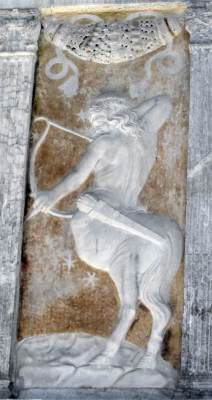

In [13]:
print(train_captions[0])
Image.open(img_name[4])

In [14]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from tqdm import tqdm

In [16]:
# Get unique images
encode_train = sorted(set(img_name))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


In [17]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [18]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [19]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [20]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.85)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(397, 397, 71, 71)

In [22]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 15
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [23]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [29]:
for i in dataset:
  print(i[1].shape)
  break

(50,)


In [26]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
for i in dataset:
  print(i[0].shape)
  break

tf.Tensor(
[[0.5298456  0.         0.         ... 0.         0.         1.1909933 ]
 [1.2647551  0.         1.1592888  ... 0.3715997  0.         0.7328429 ]
 [0.61379576 0.0568025  2.730461   ... 1.2157189  0.07184347 0.40545067]
 ...
 [0.813899   0.         0.5915162  ... 0.38698855 0.         0.01100817]
 [0.12901562 0.         0.2394015  ... 0.25389823 0.         0.37229064]
 [0.         0.         0.36921787 ... 0.17818911 0.         0.7039821 ]], shape=(64, 2048), dtype=float32)


In [33]:
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [81]:
for i in dataset:
  print(i[0].shape)
  break

(15, 64, 2048)


In [69]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [70]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [71]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)  

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [72]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [73]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [74]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [75]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [76]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [77]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  print(img_tensor.shape)

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [78]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

(15, 64, 2048)


KeyboardInterrupt: ignored

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
for i in range(30):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                           for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)